<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import itertools
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_recall_curve) 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import bernoulli
from scipy.stats import norm
import scipy.stats
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
import seaborn as sns
import arviz as az
import pymc3 as pm
import theano.tensor as tt
from IPython.core.pylabtools import figsize
warnings.filterwarnings("ignore")
print(f"Running on PyMC3 v{pm.__version__}")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Running on PyMC3 v3.11.4


#Inferencia Bayesiana
queremos saber las distribuciones de probabilidad de los parámetros desconocidos del modelo.

Probar que tan buenos son unos parámetros. Cuanto mayor sea la probabilidad P(teta|x) de los valores de los parámetros dados los datos, más probable será que sean los parámetros "reales" de la distribución de la población.

Esto significa que podemos transformar nuestro problema de encontrar los parámetros de la distribución de la población, a encontrar los valores de los parámetros que maximizan el valor P(θ|x).

podemos transformar nuestro problema de encontrar los parámetros de la distribución de la población, a encontrar los valores de los parámetros que maximizan el valor P(θ|x).

Leemos los datos para un ejemplo de dos variables

In [2]:
df = pd.read_csv('bones.csv')
df = df.assign(const=1)
#print(df)
dfy = df['frac'] 
dfx = df[['const','sex','age']] ## Predictors
x   = pd.DataFrame(df[['sex','age']]).to_numpy()
y   = pd.DataFrame(df[['frac']]).to_numpy()
df.sample(5)
df.describe()

,sex,age,frac,const
count,100.00,100.000000,100.000000,100.0
mean,0.55,64.980000,0.630000,1.0
std,0.50,8.671304,0.485237,0.0
min,0.00,50.000000,0.000000,1.0
25%,0.00,57.000000,0.000000,1.0
50%,1.00,66.000000,1.000000,1.0
75%,1.00,72.000000,1.000000,1.0
max,1.00,80.000000,1.000000,1.0


## Un ejemplo básico de regresión logistica bayesiana
El ejemplo usado es un modelo de regresión logística simulado de fracturas óseas con variables independientes de edad y sexo. Fuente: [Lawrence Joseph](http://www.medicine.mcgill.ca/epidemiology/Joseph/courses/EPIB-621/main.html) [PDF](http://www.medicine.mcgill.ca/epidemiology/joseph/courses/EPIB-621/bayeslogit.pdf)

Al principio no sabemos nada sobre los parámetros `beta` así que usaremos una distribución **uniforme**  con límites suficientemente grandes como los valores: `lower = -10**6; higher = 10**6 `


In [3]:
lower = -10**6; higher = 10**6
with pm.Model() as first_model:
    ## Priors on parameters
    beta_0   = pm.Uniform('beta_0', lower=lower, upper= higher)
    beta_sex = pm.Uniform('beta_sex', lower, higher)
    beta_age = pm.Uniform('beta_age', lower, higher)
    
    #the probability of output equal to 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_sex*df['sex']+ beta_age*df['age']))

with first_model:
    #fit the data 
    observed=pm.Bernoulli("frac", p, observed=df['frac'])
    start = pm.find_MAP()
    step  = pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(25000, step=step, start=start)
    first_burned_trace=trace[15000:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta_age]
>Metropolis: [beta_sex]
>Metropolis: [beta_0]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 33 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


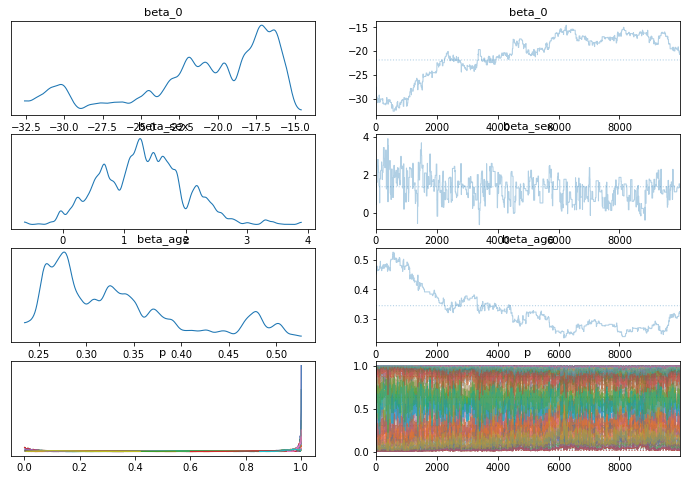

In [4]:
##Graficamos las distribuciones resultantes de nuestro primer modelo
pm.traceplot(first_burned_trace)
plt.savefig('fig_t8_1.png', transparent=True)
plt.show()

In [5]:
## Ahora calculamos la media de nuestra primera versión de las muestras generadas por la simulación.
coeffs=['beta_0', 'beta_sex', 'beta_age']
d=dict()
for item in coeffs:
    d[item]=[first_burned_trace[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
result_coeffs
#coeff_result=pd.DataFrame(d)    
#coeff_result

,beta_0,beta_sex,beta_age
0,-21.368124,1.336175,0.337271


Una ventaja del enfoque de inferencia bayesiana es que no solo nos da la media de los parámtros del modelo, también podemos obtener los intervalos de confianza al 95%. Es decir que los Los parámetros buscados se encontrarán entre los valores siguientes con una probabilidad del 95%. 

In [6]:
mean = first_burned_trace['beta_0'].mean()
hpd = az.hdi(first_burned_trace['beta_0'].flatten())

coeffs=['beta_0', 'beta_sex', 'beta_age']
interval=dict()
for item in coeffs:
    interval[item]=az.hdi(first_burned_trace[item].flatten()) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
result_coeffs

,beta_0,beta_sex,beta_age
lower,-27.907344,0.172043,0.237758
upper,-15.143336,2.237783,0.441337


Los valores buscados se encuentran entre estos valores, ahora podemos refinar la búsqueda de los parámetros usando estos límites en un segundo modelo.

In [7]:
with pm.Model() as second_model:
    ## Priors on parameters
    beta_0   = pm.Uniform('beta_0',   lower=-31.561240, upper= -20.376186)
    beta_sex = pm.Uniform('beta_sex', lower=0.555843,   upper=2.816436)
    beta_age = pm.Uniform('beta_age', lower=0.314423,   upper=0.487489)
    
    #the probability of output equal to 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_sex*df['sex']+ beta_age*df['age']))
    
with second_model:
    #fit the data 
    observed=pm.Bernoulli("frac", p, observed=df['frac'])
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(25000, step=step, start=start)
    second_burned_trace=trace[15000:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta_age]
>Metropolis: [beta_sex]
>Metropolis: [beta_0]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 33 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


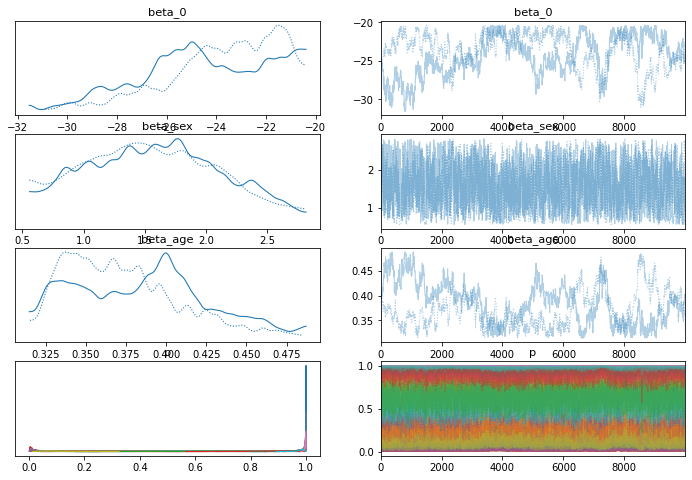

In [8]:
##Graficamos las distribuciones resultantes de nuestro segundo modelo
pm.traceplot(second_burned_trace)
plt.savefig('fig_t8_2.png', transparent=True)
plt.show()

In [9]:
## Ahora calculamos la media de nuestra primera versión de las muestras generadas por la simulación.
coeffs=['beta_0', 'beta_sex', 'beta_age']
d=dict()
for item in coeffs:
    d[item]=[second_burned_trace[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
print(result_coeffs)

     beta_0  beta_sex  beta_age
0 -24.06409   1.57659  0.378664


In [10]:
## Ahora calculamos intervalos al 95%.
mean = second_burned_trace['beta_0'].mean()
hpd = az.hdi(second_burned_trace['beta_0'].flatten())

coeffs=['beta_0', 'beta_sex', 'beta_age']
interval=dict()
for item in coeffs:
    interval[item]=az.hdi(second_burned_trace[item].flatten()) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
print(result_coeffs)

          beta_0  beta_sex  beta_age
lower -28.420887  0.555946  0.316755
upper -20.400473  2.465139  0.449447


Ahora, entrenemos el modelo asumiendo que los coeficientes de la regresión logistica siguen distribuciones normales. Es decir cambiaremos el conjunto de priors en un tercer modelo.

In [11]:
with pm.Model() as third_model:  
    ## Priors on parameters
    beta_0   = pm.Normal('beta_0'  , mu=-23.764747, sd=10**4)
    beta_sex = pm.Normal('beta_sex', mu=1.572192, sd=10**4)
    beta_age = pm.Normal('beta_age', mu=0.37384, sd=10**4)
    
    #the probability of output equal to 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_sex*df['sex']+ beta_age*df['age']))
    
with third_model:
    #fit the data 
    observed=pm.Bernoulli("frac", p, observed=df['frac'])
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(25000, step=step, start=start)
    third_burned_trace=trace[15000:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta_age]
>Metropolis: [beta_sex]
>Metropolis: [beta_0]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 33 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


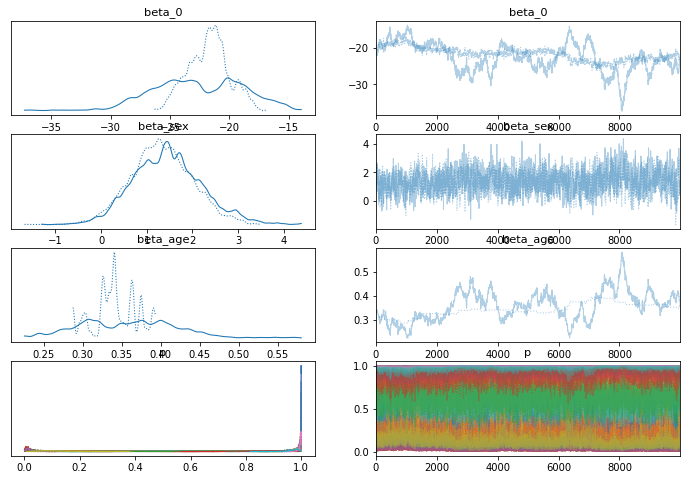

In [12]:
##Graficamos las distribuciones resultantes de nuestro tercer modelo
pm.traceplot(third_burned_trace)
plt.savefig('fig_t8_3.png', transparent=True)
plt.show()

In [13]:
## Ahora calculamos la media de nuestra primera versión de las muestras generadas por la simulación.
coeffs=['beta_0', 'beta_sex', 'beta_age']
d=dict()
for item in coeffs:
    d[item]=[third_burned_trace[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
print(result_coeffs)

      beta_0  beta_sex  beta_age
0 -22.233445  1.390688  0.350679


In [14]:
## Ahora calculamos intervalos al 95%.
mean = third_burned_trace['beta_0'].mean()
hpd = az.hdi(third_burned_trace['beta_0'].flatten())

coeffs=['beta_0', 'beta_sex', 'beta_age']
interval=dict()
for item in coeffs:
    interval[item]=az.hdi(third_burned_trace[item].flatten()) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
print(result_coeffs)

          beta_0  beta_sex  beta_age
lower -28.800524 -0.055693  0.265425
upper -17.061508  2.692835  0.444702


Como podemos ver los intervalos son mas cerrados a los que teníamos en el primer modelo.

## Modelo lineal generalizado (GLM) en PyMC3 en fracturas oseas.
Hemos hecho un análisis inferencial bayesiano expresando los priors de cada una de las variables. Sin embargo, cuando el número de variables es muy grande, **PyMC3** tiene un modelo lineal generalizado en el que todo esta automatizado. Se usará este modelo para ajustar nuestros datos.

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [age, sex, Intercept]


Sampling 2 chains for 10_000 tune and 25_000 draw iterations (20_000 + 50_000 draws total) took 219 seconds.
There were 4078 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.24768078666896254, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


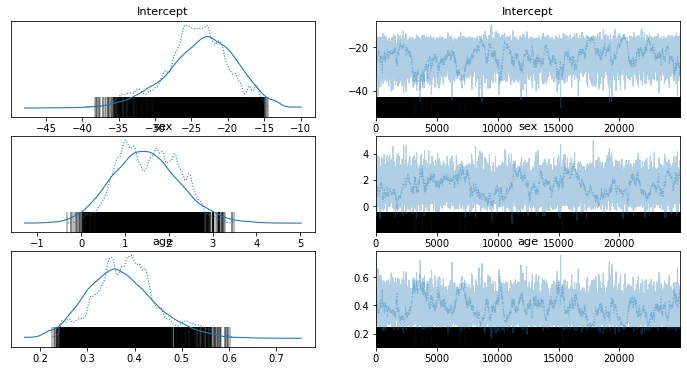

In [15]:
with pm.Model() as fourth_model:
    pm.glm.GLM.from_formula('frac ~ sex + age',df, 
                            family=pm.glm.families.Binomial())
    fourth_trace = pm.sample(25000, tune=10000, init='adapt_diag')
pm.traceplot(fourth_trace)
plt.savefig('fig_t8_4.png', transparent=True)
plt.show()

In [16]:
pm.summary(fourth_trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-24.040,4.682,-32.968,-15.136,0.404,0.288,135.0,199.0,1.02
sex,1.514,0.725,0.171,2.819,0.069,0.049,111.0,871.0,1.00
age,0.379,0.073,0.243,0.521,0.006,0.004,149.0,188.0,1.02


In [17]:
with fourth_model:
    map_solution=pm.find_MAP()
d=dict()
for item in map_solution.keys():
    d[item]=[float(map_solution[item])]
    
fourth_map_coeffs=pd.DataFrame.from_dict(d)    
fourth_map_coeffs

,Intercept,sex,age
0,0.011293,0.008253,0.999902


In [18]:
## Ahora calculamos la media de nuestra primera versión de las muestras generadas por la simulación.
coeffs=['age', 'sex', 'Intercept']
d=dict()
for item in coeffs:
    d[item]=[fourth_trace[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
print(result_coeffs)

        age       sex  Intercept
0  0.378962  1.514401 -24.040393


In [19]:
## Ahora calculamos intervalos al 95%.
mean = fourth_trace['Intercept'].mean()
hpd = az.hdi(fourth_trace['Intercept'].flatten())

coeffs=['age', 'sex', 'Intercept']
interval=dict()
for item in coeffs:
    interval[item]=az.hdi(fourth_trace[item].flatten()) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
print(result_coeffs)

            age       sex  Intercept
lower  0.242787  0.170689 -32.968387
upper  0.520933  2.819042 -15.136175


Por último, calculamos la matriz de confusión del ajuste al modelo de regresión logistica

In [20]:
with fourth_model:
    ppc = pm.sample_posterior_predictive(fourth_trace, samples=15000)
#compute y_score 
with fourth_model:
    fourth_y_score = np.mean(ppc['y'], axis=0)
#convert y_score into binary decisions    
fourth_model_prediction=[1 if x >0.5 else 0 for x in fourth_y_score]
#compute confussion matrix 
fourth_model_confussion_matrix = confusion_matrix(df['frac'], fourth_model_prediction)
fourth_model_confussion_matrix

array([[30,  7],
       [ 5, 58]])

## Versión frecuentista de la regresión logística con la librería *statsmodel*.

Ahora, comparamos los resultados con un análisis frecuentista de regresión logística de la librería **statsmodels**.

In [21]:
model = sm.Logit(dfy, dfx)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.297593
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   frac   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Tue, 22 Feb 2022   Pseudo R-squ.:                  0.5484
Time:                        20:57:18   Log-Likelihood:                -29.759
converged:                       True   LL-Null:                       -65.896
Covariance Type:            nonrobust   LLR p-value:                 2.024e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.8504      4.425     -4.938      0.000     -30.524     -13.177
sex            1.3611      0.

##Predicción de sobrecarga en grupos de líneas de transmisión.
En esta sección se usará inferencia bayesiana para ajustar un modelo de regresión logística a datos de violación de flujo de potencia eléctrica en grupos de líneas de transmisión, que interconectan regiones eléctricas. La variable dependientes es de naturaleza binaria con un valor de uno si la línea presenta sobrecarga y cero si no. Las variables independientes son el flujo neto máximo y mínimo en la región eléctrica en un día y se calcula como la diferencia entre la demanda menos la generación en cada región.


In [22]:
df = pd.read_csv('overload.csv')
df = df.assign(const=1)
print(df)
dfy = df['L3'] #Se escoge le número de línea de transmisión
dfx = df[['CEN','NES','NOR','NTE','OCC','ORI','PEN','CEN_min','NES_min','NOR_min','NTE_min','OCC_min','ORI_min','PEN_min']] ## Predictors
df.sample(5)
df.describe()

     Unnamed: 0  Num  L1  L2  L3  ...  GUA_min  WE2_min  PEE_min  BEL_min  const
0             0  100   0   0   1  ...    120.0        0        0        0      1
1             1  101   0   0   1  ...    109.0        0        0        0      1
2             2  102   0   0   1  ...    120.0        0        0        0      1
3             3  103   0   1   1  ...    115.0        0        0        0      1
4             4  104   0   0   1  ...    109.0        0        0        0      1
..          ...  ...  ..  ..  ..  ...      ...      ...      ...      ...    ...
330         330   95   0   0   1  ...    105.0        0        0        0      1
331         331   96   0   0   0  ...    120.0        0        0        0      1
332         332   97   0   0   0  ...    105.0        0        0        0      1
333         333   98   0   0   1  ...    120.0        0        0        0      1
334         334   99   0   0   1  ...    109.0        0        0        0      1

[335 rows x 131 columns]


,Unnamed: 0,Num,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,L22,L23,L24,L25,L26,L27,L28,L29,L30,L31,L32,L33,L34,L35,L36,L37,L38,...,L90,L91,L92,L93,L94,L95,L96,L97,L98,L99,L100,L101,L102,L103,L104,L105,L106,CEN,ORI,OCC,NOR,NTE,NES,PEN,GUA,WE2,PEE,BEL,CEN_min,ORI_min,OCC_min,NOR_min,NTE_min,NES_min,PEN_min,GUA_min,WE2_min,PEE_min,BEL_min,const
count,335.0000,335.000000,335.0,335.000000,335.000000,335.0,335.000000,335.000000,335.000000,335.0,335.0,335.0,335.0,335.0,335.0,335.000000,335.000000,335.0,335.0,335.0,335.000000,335.000000,335.0,335.000000,335.0,335.000000,335.0,335.0,335.0,335.000000,335.0,335.0,335.000000,335.000000,335.000000,335.0,335.000000,335.0,335.000000,335.000000,...,335.000000,335.0,335.000000,335.000000,335.000000,335.000000,335.0,335.0,335.0,335.0,335.000000,335.0,335.0,335.000000,335.00000,335.000000,335.0,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.0,335.0,335.0,335.0
mean,167.0000,207.558209,0.0,0.020896,0.564179,0.0,0.119403,0.376119,0.435821,0.0,0.0,0.0,0.0,0.0,0.0,0.008955,0.020896,0.0,0.0,0.0,0.047761,0.026866,0.0,0.217910,0.0,0.002985,0.0,0.0,0.0,0.002985,0.0,0.0,0.232836,0.065672,0.029851,0.0,0.020896,0.0,0.008955,0.423881,...,0.170149,0.0,0.749254,0.749254,0.504478,0.504478,0.0,0.0,0.0,0.0,0.008955,0.0,0.0,0.029851,0.01194,0.077612,0.0,3531.016257,-734.349597,3447.496281,-398.745606,587.670704,-3712.398660,515.603887,174.177621,29.793949,29.793949,29.793949,1678.982731,-2222.907749,1845.443134,-1045.121707,-570.474549,-5481.648493,183.962728,107.731460,0.0,0.0,0.0,1.0
std,96.8504,98.931093,0.0,0.143249,0.496606,0.0,0.324747,0.485135,0.496606,0.0,0.0,0.0,0.0,0.0,0.0,0.094348,0.143249,0.0,0.0,0.0,0.213580,0.161933,0.0,0.413444,0.0,0.054636,0.0,0.0,0.0,0.054636,0.0,0.0,0.423271,0.248078,0.170430,0.0,0.143249,0.0,0.094348,0.494911,...,0.376326,0.0,0.434091,0.434091,0.500728,0.500728,0.0,0.0,0.0,0.0,0.094348,0.0,0.0,0.170430,0.10878,0.267960,0.0,431.457293,670.089562,732.043225,676.016881,562.790563,920.126065,619.126820,537.710521,545.318809,545.318809,545.318809,280.700271,489.156797,723.876677,356.460072,199.639984,491.556047,292.741960,14.709865,0.0,0.0,0.0,0.0
min,0.0000,25.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,2705.591000,-1694.139000,2002.898000,-1242.877000,89.691000,-5038.948000,21.336000,114.000000,0.000000,0.000000,0.000000,0.000000,-3409.860000,0.000000,-1710.495000,-998.826000,-6282.699000,-248.764000,0.000000,0.0,0.0,0.0,1.0
25%,83.5000,122.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.500000,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,3384.032500,-953.392000,2983.881500,-718.417500,401.472000,-4170.805000,225.004000,139.000000,0.000000,0.000000,0.000000,1539.116500,-2573.634500,1310.903500,-1337.659500,-723.338500,-5741.964500,-40.723000,108.728000,0.0,0.0,0.0,1.0
50%,167.0000,206.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,3523.580000,-777.844000,3651.682000,-434.835000,547.926000,-3672.69700

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [PEN_min, PEE_min, ORI_min, OCC_min, NTE_min, NOR_min, NES_min, GUA_min, CEN_min, PEN, PEE, ORI, OCC, NTE, NOR, NES, GUA, CEN, Intercept]


Sampling 2 chains for 10_000 tune and 25_000 draw iterations (20_000 + 50_000 draws total) took 3155 seconds.
There were 17824 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36888 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


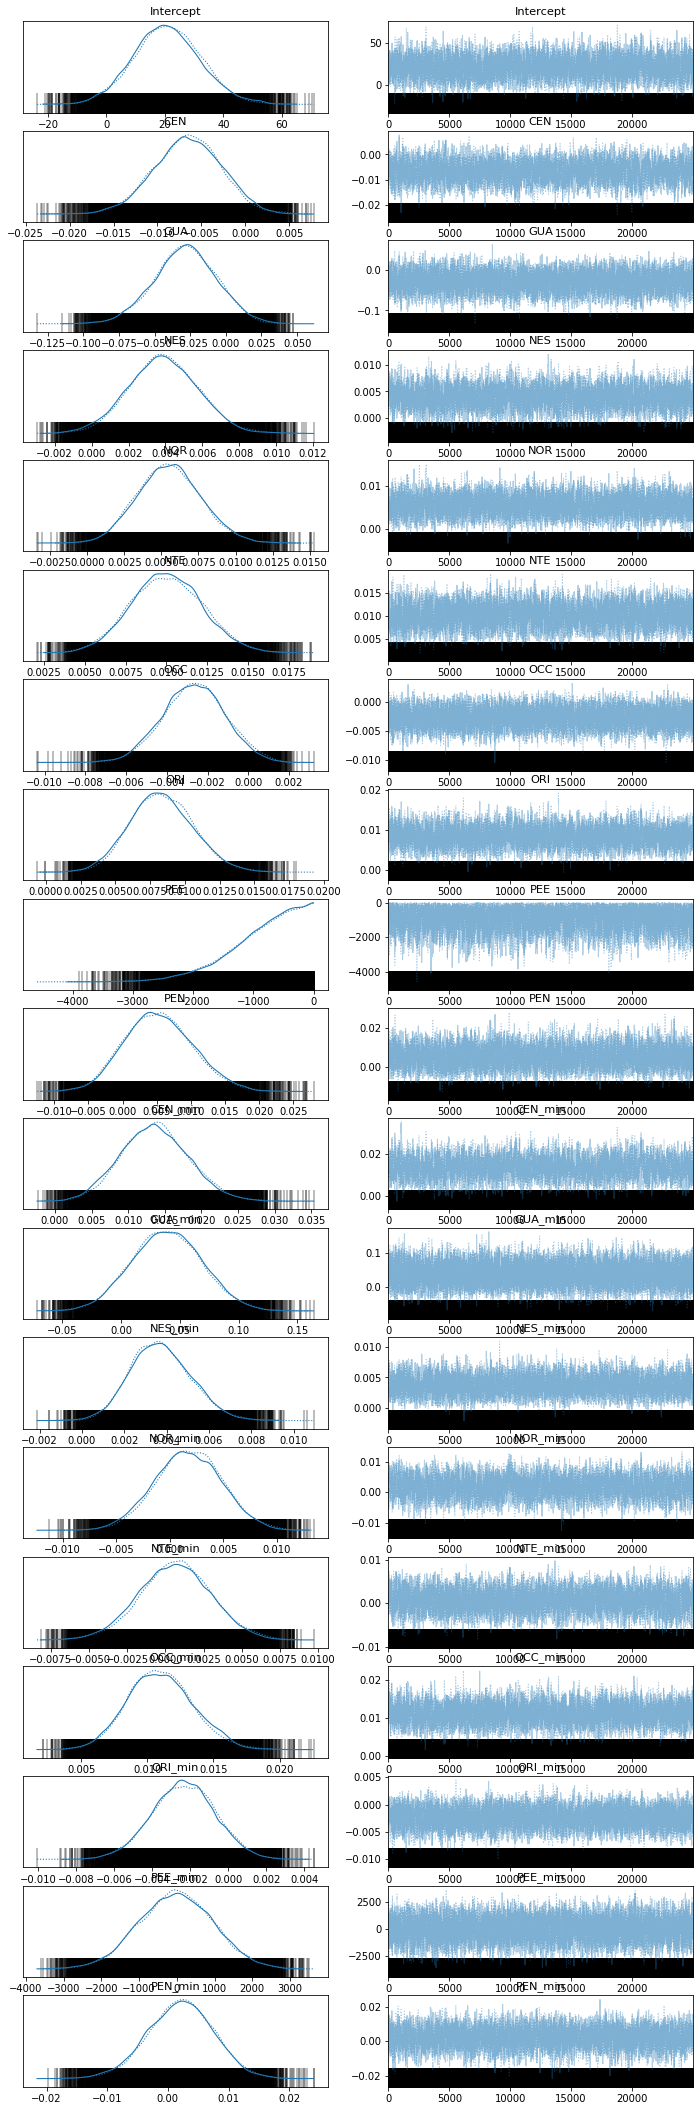

In [23]:
with pm.Model() as fourth_model:
    pm.glm.GLM.from_formula('L3 ~ CEN + GUA + NES + NOR + NTE + OCC + ORI + PEE + PEN + CEN_min + GUA_min + NES_min + NOR_min + NTE_min + OCC_min + ORI_min + PEE_min + PEN_min',df, 
                            family=pm.glm.families.Binomial())
    fourth_trace = pm.sample(25000, tune=10000, init='adapt_diag')
pm.traceplot(fourth_trace)

plt.savefig('fig_t8_5.png', transparent=True)
plt.show()

In [24]:
pm.summary(fourth_trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,20.732,11.468,-0.946,42.319,0.207,0.146,3085.0,6246.0,1.0
CEN,-0.007,0.004,-0.014,0.001,0.000,0.000,2493.0,4403.0,1.0
GUA,-0.028,0.022,-0.071,0.011,0.000,0.000,3947.0,7391.0,1.0
NES,0.004,0.002,0.000,0.007,0.000,0.000,2297.0,4442.0,1.0
NOR,0.006,0.002,0.002,0.010,0.000,0.000,3583.0,5768.0,1.0
NTE,0.010,0.002,0.006,0.014,0.000,0.000,2924.0,5509.0,1.0
OCC,-0.003,0.002,-0.006,0.000,0.000,0.000,4357.0,6778.0,1.0
ORI,0.008,0.002,0.004,0.013,0.000,0.000,2739.0,4528.0,1.0
PEE,-803.467,604.146,-1886.697,-0.142,9.675,6.841,3559.0,5415.0,1.0
PEN,0.005,0.005,-0.004,0.015,0.000,0.000,3690.0,6073.0,1.0


In [25]:
with fourth_model:
    map_solution=pm.find_MAP()
d=dict()
for item in map_solution.keys():
    d[item]=[float(map_solution[item])]
    
fourth_map_coeffs=pd.DataFrame.from_dict(d)    
fourth_map_coeffs

,Intercept,CEN,GUA,NES,NOR,NTE,OCC,ORI,PEE,PEN,CEN_min,GUA_min,NES_min,NOR_min,NTE_min,OCC_min,ORI_min,PEE_min,PEN_min
0,0.000085,0.213264,-0.004122,-0.174764,-0.172353,0.096798,0.526738,-0.190898,-0.019711,-0.103194,0.099892,0.013375,-0.385538,-0.216267,0.015532,0.445573,-0.384268,0.0,-0.089127


In [26]:
## Ahora calculamos la media de de las muestras generadas por la simulación.
coeffs=['CEN','GUA','NES','NOR','NTE','OCC','ORI','PEE','PEN','CEN_min','GUA_min','NES_min','NOR_min','NTE_min','OCC_min','ORI_min','PEE_min','PEN_min','Intercept']
d=dict()
for item in coeffs:
    d[item]=[fourth_trace[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
print(result_coeffs)

        CEN       GUA       NES  ...    PEE_min   PEN_min  Intercept
0 -0.006583 -0.028382  0.003885  ... -22.030502  0.002098   20.73217

[1 rows x 19 columns]


In [27]:
## Ahora calculamos intervalos al 95%.
mean = fourth_trace['Intercept'].mean()
hpd = az.hdi(fourth_trace['Intercept'].flatten())

coeffs=['CEN','GUA','NES','NOR','NTE','OCC','ORI','PEE','PEN','CEN_min','GUA_min','NES_min','NOR_min','NTE_min','OCC_min','ORI_min','PEE_min','PEN_min','Intercept']
interval=dict()
for item in coeffs:
    interval[item]=az.hdi(fourth_trace[item].flatten()) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
print(result_coeffs)

            CEN       GUA       NES  ...      PEE_min   PEN_min  Intercept
lower -0.013748 -0.071356  0.000321  ... -1791.789576 -0.008037  -0.945730
upper  0.000591  0.011021  0.007333  ...  1910.403694  0.012323  42.319036

[2 rows x 19 columns]


Por último, calculamos la matriz de confusión del ajuste al modelo de regresión logistica

In [28]:
with fourth_model:
    ppc = pm.sample_posterior_predictive(fourth_trace, samples=15000)
#compute y_score 
with fourth_model:
    fourth_y_score = np.mean(ppc['y'], axis=0)
#convert y_score into binary decisions    
fourth_model_prediction=[1 if x >0.5 else 0 for x in fourth_y_score]
#compute confussion matrix 
fourth_model_confussion_matrix = confusion_matrix(df['L3'], fourth_model_prediction)
fourth_model_confussion_matrix

array([[103,  43],
       [ 17, 172]])

### **Conclusión:** 
Hemos utilizado **PyMC3** para implementar la regresión logistica bayesiana para varias variables, además de la función **Logit** de la librería *statsmodel*, que implementa un enfoque frecuentista.
Los resultados de estimación de parámetros entre el enfoque frecuentista y el bayesiano son muy parecidos, sin embargo, el enfoque bayesiano da algunas ventajas ya que da la posibilidad de actualizar el modelo con nueva información, mientras que los modelos de regresión lineal generan valores únicos de los parámetros de ajuste, mientras que los modelos de regresión lineal bayesianos pueden generar distribuciones de los parámetros.
Esto tiene la ventaja de que podemos cuantificar la incertidumbre de nuestra estimación.
Otra cosa que observamos es que a pesar de que los modelos modelos bayesianos que usamos usan distribuciones prior diferentes, los rendimientos de predicción son similares. Esto quiere decir que a medida que crece el conjunto de datos los resultados deberían converger en la misma solución.

[Bayesian logistic regression with PyMC3](https://towardsdatascience.com/bayesian-logistic-regression-with-pymc3-8e17c576f31a)

[Bayesian Linear Regression in Python via PyMC3](https://towardsdatascience.com/bayesian-linear-regression-in-python-via-pymc3-ab8c2c498211)

[PyMC3](https://docs.pymc.io/en/v3/nb_examples/index.html)

[Logistic regression with PyMC3](https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/)

[Bayesian statistics by Lawrence Joseph (Medicine)](http://www.medicine.mcgill.ca/epidemiology/Joseph/courses/EPIB-621/main.html) [PDF](http://www.medicine.mcgill.ca/epidemiology/joseph/courses/EPIB-621/bayeslogit.pdf)

[Bayesian Learning for Machine Learning: Part II - Linear Regression](https://wso2.com/blog/research/part-two-linear-regression/)

[An Introduction to Logistic Regression in Python](https://www.simplilearn.com/tutorials/machine-learning-tutorial/logistic-regression-in-python)

[Bayesian inference tutorial: a hello world example](https://datapythonista.me/blog/bayesian-inference-tutorial-a-hello-world-example.html)

[Ejemplo de Bayes con covid y síntomas](https://statsthinking21.github.io/statsthinking21-python/10-BayesianStatistics.html)

[Estimating Probabilities with Bayesian Modeling in Python](https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815)

[Estimando probabilidades con inferencia bayesiana](https://github.com/WillKoehrsen/probabilistic-programming/blob/master/Estimating%20Probabilities%20with%20Bayesian%20Inference.ipynb)

Bayesian Linear Regression in Python: Using Machine Learning to Predict Student Grades: [Parte 1](https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-1-7d0ad817fca5) y [Parte2](https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e)

[Bayesian Inference in Python](https://towardsai.net/p/l/bayesian-inference-in-python) 

[Bayesian Statistics explained to Beginners in Simple English](Bayesian Statistics explained to Beginners in Simple English)

[Bayesian inference in Python-coursera](https://www.coursera.org/lecture/advanced-machine-learning-signal-processing/bayesian-inference-in-python-9D2Pz)

[A Guide to Bayesian Statistics in Python for Beginners](https://analyticsindiamag.com/a-guide-to-bayesian-statistics-in-python-for-beginners/)

[BBN: Bayesian Belief Networks — How to Build Them Effectively in Python](https://towardsdatascience.com/bbn-bayesian-belief-networks-how-to-build-them-effectively-in-python-6b7f93435bba)

[Bayesian multivariate linear regression Yni](https://en.wikipedia.org/wiki/Bayesian_multivariate_linear_regression#:~:text=In%20statistics%2C%20Bayesian%20multivariate%20linear,a%20single%20scalar%20random%20variable.)

